In [137]:
import pandas as pd
from httpx import get
import numpy as np
from selectolax.parser import HTMLParser
import spacy
from nltk.corpus import stopwords
import string
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

#### Disclaimer
This ipynb file is treated as a structure rough paper and as the preprocessing is indivual to each scrapper, I decided include cleaning process with the scraper files.

# News Scraper

In [9]:
url = "https://www.medicalnewstoday.com/news"

In [10]:
resp = get(url)

# Parsing the data using selectolax HTML Parser
tree = HTMLParser(resp.text)

headlines = [h.text() for h in tree.css("h2")]
summaries = [s.text() for s in tree.css("p a")]
dates = [d.text() for d in tree.css("figure + div > div")]
links = [l.attributes['href'] for l in tree.css("p a")]

In [11]:
print(f"Headlines: {len(headlines)}")
print(f"Summaries: {len(summaries)}")
print(f"Dates: {len(dates)}")
print(f"Links: {len(links)}")

Headlines: 40
Summaries: 40
Dates: 40
Links: 40


In [12]:
df = pd.DataFrame(
        {
            "Headline": headlines,
            "Summary": summaries,
            "Date": dates,
            "Link": links
        }
    )

df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Headline,Summary,Date,Link
0,Red wine or white? Which one is worse for canc...,"White wine may increase the risk for cancer, r...",2025-03-22,https://www.medicalnewstoday.com/articles/is-r...
1,Healthy plant-based diets may help people with...,Eating a healthy plant-based diet that include...,2025-03-21,https://www.medicalnewstoday.com/articles/heal...
2,Can exercising help you live longer? Twin stud...,Higher and more intense levels of physical act...,2025-03-21,https://www.medicalnewstoday.com/articles/can-...
3,Anti-amyloid drug may help reduce the risk of ...,An early Alzheimer's treatment that removes am...,2025-03-20,https://www.medicalnewstoday.com/articles/anti...
4,Scientists unveil how key protein malfunctions...,Researchers have revealed for the first time h...,2025-03-20,https://www.medicalnewstoday.com/articles/scie...


In [13]:
nlp = spacy.load("en_core_web_sm")

def preprocess(text):

    stop_words = set(stopwords.words("english"))
    punctuations = string.punctuation

    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.text.lower() not in stop_words and token.text not in punctuations]

    return " ".join(tokens)

In [14]:
df['Preprocessed_Summary'] = df['Summary'].apply(preprocess)

df.head()

,Headline,Summary,Date,Link,Preprocessed_Summary
0,Red wine or white? Which one is worse for canc...,"White wine may increase the risk for cancer, r...",2025-03-22,https://www.medicalnewstoday.com/articles/is-r...,white wine may increase risk cancer recent coh...
1,Healthy plant-based diets may help people with...,Eating a healthy plant-based diet that include...,2025-03-21,https://www.medicalnewstoday.com/articles/heal...,eat healthy plant base diet include vegetable ...
2,Can exercising help you live longer? Twin stud...,Higher and more intense levels of physical act...,2025-03-21,https://www.medicalnewstoday.com/articles/can-...,high intense level physical activity may benef...
3,Anti-amyloid drug may help reduce the risk of ...,An early Alzheimer's treatment that removes am...,2025-03-20,https://www.medicalnewstoday.com/articles/anti...,early alzheimer 's treatment remove amyloid pl...
4,Scientists unveil how key protein malfunctions...,Researchers have revealed for the first time h...,2025-03-20,https://www.medicalnewstoday.com/articles/scie...,researcher reveal first time key protein link ...


In [15]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [16]:
df['Sentiment'] = df['Preprocessed_Summary'].apply(get_sentiment)
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: "Positive" if x>0 else "Negative" if x < 0 else "Neutral")

df.head()

,Headline,Summary,Date,Link,Preprocessed_Summary,Sentiment,Sentiment_Label
0,Red wine or white? Which one is worse for canc...,"White wine may increase the risk for cancer, r...",2025-03-22,https://www.medicalnewstoday.com/articles/is-r...,white wine may increase risk cancer recent coh...,0.000000,Neutral
1,Healthy plant-based diets may help people with...,Eating a healthy plant-based diet that include...,2025-03-21,https://www.medicalnewstoday.com/articles/heal...,eat healthy plant base diet include vegetable ...,-0.150000,Negative
2,Can exercising help you live longer? Twin stud...,Higher and more intense levels of physical act...,2025-03-21,https://www.medicalnewstoday.com/articles/can-...,high intense level physical activity may benef...,0.065939,Positive
3,Anti-amyloid drug may help reduce the risk of ...,An early Alzheimer's treatment that removes am...,2025-03-20,https://www.medicalnewstoday.com/articles/anti...,early alzheimer 's treatment remove amyloid pl...,0.300000,Positive
4,Scientists unveil how key protein malfunctions...,Researchers have revealed for the first time h...,2025-03-20,https://www.medicalnewstoday.com/articles/scie...,researcher reveal first time key protein link ...,0.125000,Positive


In [17]:
tfidf = TfidfVectorizer(max_df=0.85, max_features=50)

tfidf_matrix = tfidf.fit_transform(df['Preprocessed_Summary'])
feature_names = tfidf.get_feature_names_out()

In [18]:
def get_top_keywords(tfidf_matrix, feature_names, n):
    top_keywords = []
    
    for doc in tfidf_matrix:
        top_indices = doc.toarray().argsort()[0][-n:][::-1]
        top_keywords.append([feature_names[i] for i in top_indices])

In [19]:
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    return entities

In [20]:
df['Top_Keywords'] = get_top_keywords(tfidf_matrix, feature_names, 6)
df['Entities']= df['Preprocessed_Summary'].apply(extract_entities)

df.head()

,Headline,Summary,Date,Link,Preprocessed_Summary,Sentiment,Sentiment_Label,Top_Keywords,Entities
0,Red wine or white? Which one is worse for canc...,"White wine may increase the risk for cancer, r...",2025-03-22,https://www.medicalnewstoday.com/articles/is-r...,white wine may increase risk cancer recent coh...,0.000000,Neutral,None,[]
1,Healthy plant-based diets may help people with...,Eating a healthy plant-based diet that include...,2025-03-21,https://www.medicalnewstoday.com/articles/heal...,eat healthy plant base diet include vegetable ...,-0.150000,Negative,None,[]
2,Can exercising help you live longer? Twin stud...,Higher and more intense levels of physical act...,2025-03-21,https://www.medicalnewstoday.com/articles/can-...,high intense level physical activity may benef...,0.065939,Positive,None,[]
3,Anti-amyloid drug may help reduce the risk of ...,An early Alzheimer's treatment that removes am...,2025-03-20,https://www.medicalnewstoday.com/articles/anti...,early alzheimer 's treatment remove amyloid pl...,0.300000,Positive,None,[]
4,Scientists unveil how key protein malfunctions...,Researchers have revealed for the first time h...,2025-03-20,https://www.medicalnewstoday.com/articles/scie...,researcher reveal first time key protein link ...,0.125000,Positive,None,"[(first, ORDINAL)]"


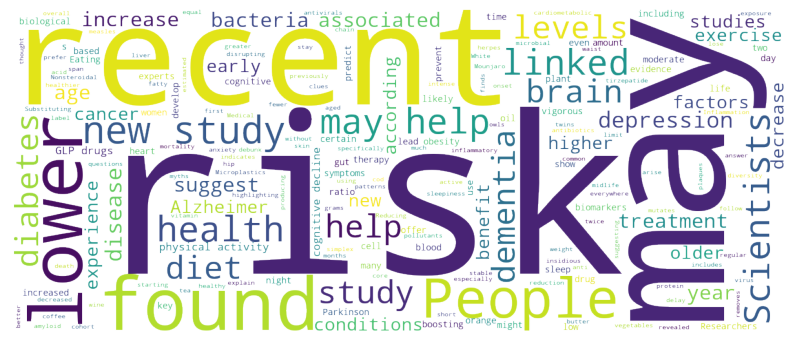

In [25]:
text = " ".join(df["Summary"].dropna())

wc = WordCloud(width=1200, height=500, background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wc.to_file("wordcloud.png")

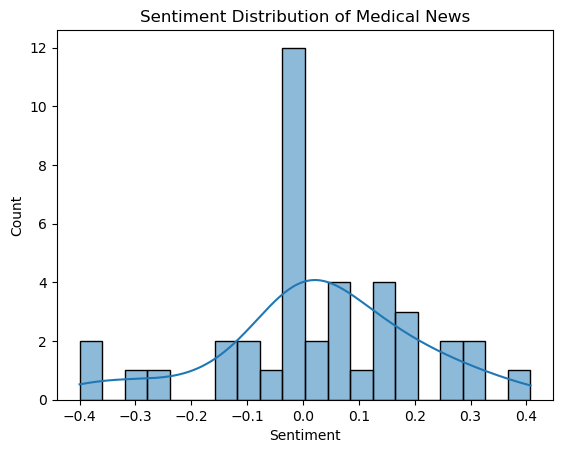

In [20]:
sns.histplot(df["Sentiment"], bins=20, kde=True)
plt.title("Sentiment Distribution of Medical News")
plt.show()

### As the website structure of 'healthline' is similar to 'medicalnewstoday', I decided to loop through the process as I have wrapped the whole script and defined a function.

# PubMed Research Articles

In [21]:
url = "https://pubmed.ncbi.nlm.nih.gov/trending/?sort=date"

In [23]:
resp = get(url)
resp.status_code

200

In [24]:
tree = HTMLParser(resp.text)
tree

<HTMLParser chars=269968>

In [25]:
ids = [id.attrs['data-article-id'] for id in tree.css("article .docsum-title")]
headings = [id.text().strip() for id in tree.css("article .docsum-title")]
links = [f"https://pubmed.ncbi.nlm.nih.gov{l.attrs['href']}" for l in tree.css("article .docsum-title")]
authors = [a.text().split(", ") for a in tree.css("article .full-authors")]
tags = [" ".join(t.text().split()[:-1]) for t in tree.css(".short-journal-citation")]
years = [int("".join(t.text().split()[-1].replace(".",""))) for t in tree.css(".short-journal-citation")]

In [26]:
df = pd.DataFrame(
        {
            "ID": ids,
            "Article": headings,
            "Authors": authors,
            "Published_Year":years,
            "Tag": tags,
            "Link": links
        }
    )

df.head()

,ID,Article,Authors,Published_Year,Tag,Link
0,40113535,Decoding microglial functions in Alzheimer's d...,"[Rao C, Semrau S, Fossati V.]",2025,Trends Immunol.,https://pubmed.ncbi.nlm.nih.gov/40113535/
1,40113530,Targeting novel immune checkpoints in the B7-H...,"[Luo Y, Yuan Y, Liu D, Peng H, Shen L, Chen Y.]",2025,Trends Cancer.,https://pubmed.ncbi.nlm.nih.gov/40113530/
2,40113355,Clinical and cost-effectiveness of lithium ver...,"[Cleare AJ, Kerr-Gaffney J, Goldsmith K, Zenas...",2025,Lancet Psychiatry.,https://pubmed.ncbi.nlm.nih.gov/40113355/
3,40113243,Rectal diclofenac versus indomethacin for prev...,"[Kang X, Xia M, Wang J, Wang X, Luo H, Qin W, ...",2025,Gut.,https://pubmed.ncbi.nlm.nih.gov/40113243/
4,40113099,"From ""Burnt-Out"" to ""Burning-Out"": Capturing L...","[Liu WY, Huang S, Ji H, Kim SU, Cheuk-Fung Yip...",2025,Gastroenterology.,https://pubmed.ncbi.nlm.nih.gov/40113099/


# COVID-19 Summary

In [27]:
url = "https://covid-19.dataflowkit.com/v1"

In [28]:
resp = get(url)
resp.status_code

200

In [30]:
# The above url is an api, so it's response will not be in a HTML ot XML format, rather it will be in a JSON format.
# It is quite easy to make a dataframe as pandas is easily read the json

df = pd.DataFrame(resp.json())
df.head()

,Active Cases_text,Country_text,Last Update,New Cases_text,New Deaths_text,Total Cases_text,Total Deaths_text,Total Recovered_text
0,,World,2025-03-22 04:04,"7,010,681","90,413","704,753,890","675,619,811",899.4
1,"334,805,269",USA,2025-03-22 04:04,"1,219,487","333,985","111,820,082","109,814,428","3,642"
2,"1,406,631,776",India,2025-03-22 04:04,"533,570","32,016","45,035,393",N/A,379
3,"65,584,518",France,2025-03-22 00:02,"167,642","612,013","40,138,560","39,970,918","2,556"
4,"83,883,596",Germany,2025-03-22 02:02,"183,027","462,891","38,828,995","38,240,600","2,182"


In [31]:
# Cleaning process
num_cols = ['Active Cases_text', 'New Cases_text', 'New Deaths_text', 'Total Cases_text', 'Total Deaths_text', 'Total Recovered_text']

for col in num_cols:
    df[col]=pd.to_numeric(df[col].map(lambda x: x.strip().replace(",","") if isinstance(x, str) else x), errors='coerce')

df.loc[0, 'Active Cases_text'] = df['Active Cases_text'].sum()

df.head()

,Active Cases_text,Country_text,Last Update,New Cases_text,New Deaths_text,Total Cases_text,Total Deaths_text,Total Recovered_text
0,7.944935e+09,World,2025-03-22 04:04,7010681.0,90413.0,704753890.0,675619811.0,899.4
1,3.348053e+08,USA,2025-03-22 04:04,1219487.0,333985.0,111820082.0,109814428.0,3642.0
2,1.406632e+09,India,2025-03-22 04:04,533570.0,32016.0,45035393.0,NaN,379.0
3,6.558452e+07,France,2025-03-22 00:02,167642.0,612013.0,40138560.0,39970918.0,2556.0
4,8.388360e+07,Germany,2025-03-22 02:02,183027.0,462891.0,38828995.0,38240600.0,2182.0


In [32]:
df['Last Update'] = pd.to_datetime(df['Last Update'], errors='coerce')

df.head()

,Active Cases_text,Country_text,Last Update,New Cases_text,New Deaths_text,Total Cases_text,Total Deaths_text,Total Recovered_text
0,7.944935e+09,World,2025-03-22 04:04:00,7010681.0,90413.0,704753890.0,675619811.0,899.4
1,3.348053e+08,USA,2025-03-22 04:04:00,1219487.0,333985.0,111820082.0,109814428.0,3642.0
2,1.406632e+09,India,2025-03-22 04:04:00,533570.0,32016.0,45035393.0,NaN,379.0
3,6.558452e+07,France,2025-03-22 00:02:00,167642.0,612013.0,40138560.0,39970918.0,2556.0
4,8.388360e+07,Germany,2025-03-22 02:02:00,183027.0,462891.0,38828995.0,38240600.0,2182.0


In [33]:
df.columns = ["_".join(i.split()) for i in df.columns.str.replace("_text","")]

df.head()

,Active_Cases,Country,Last_Update,New_Cases,New_Deaths,Total_Cases,Total_Deaths,Total_Recovered
0,7.944935e+09,World,2025-03-22 04:04:00,7010681.0,90413.0,704753890.0,675619811.0,899.4
1,3.348053e+08,USA,2025-03-22 04:04:00,1219487.0,333985.0,111820082.0,109814428.0,3642.0
2,1.406632e+09,India,2025-03-22 04:04:00,533570.0,32016.0,45035393.0,NaN,379.0
3,6.558452e+07,France,2025-03-22 00:02:00,167642.0,612013.0,40138560.0,39970918.0,2556.0
4,8.388360e+07,Germany,2025-03-22 02:02:00,183027.0,462891.0,38828995.0,38240600.0,2182.0
